In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('data/train.csv')
data.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


Lets see the data for a single item over three years

In [3]:
plt.rcParams['figure.figsize'] = (20, 10)

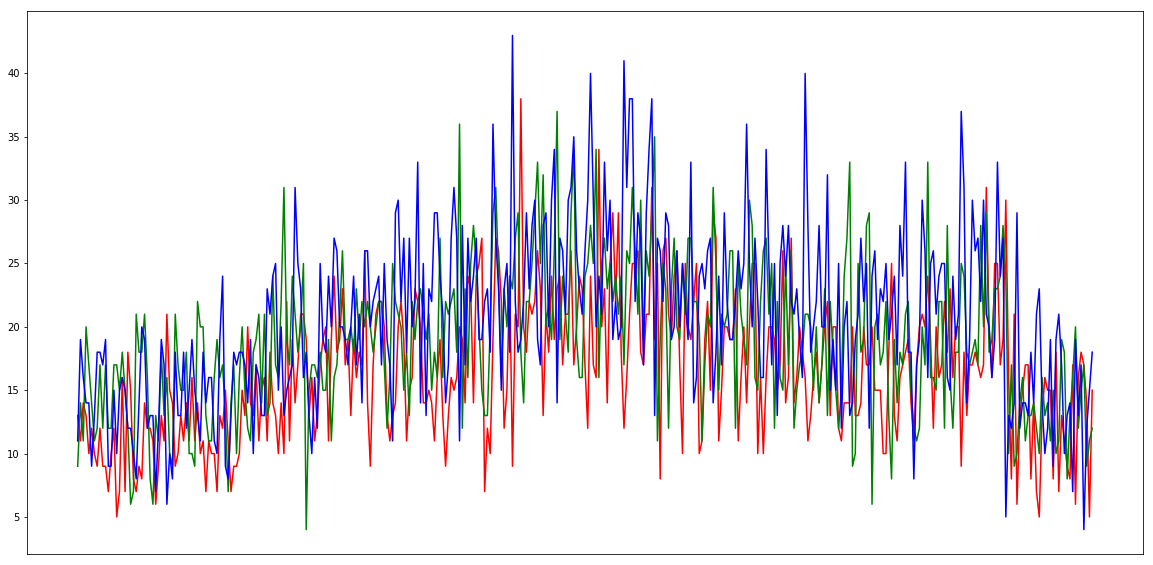

In [4]:
plt.gca().axes.get_xaxis().set_visible(False)
plt.plot(data.date.values[:365], data.sales.values[:365], 'r', data.date.values[:365], data.sales.values[365:730], 'g', data.date.values[:365], data.sales.values[730:1095], 'b')

We can see some pattern in the data.

In [5]:
data.dtypes

date     object
store     int64
item      int64
sales     int64
dtype: object

In [6]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')

Changing index to date column for easy access.

In [7]:
data = pd.read_csv('data/train.csv', parse_dates=['date'], index_col='date', date_parser=dateparse)
data.dtypes

store    int64
item     int64
sales    int64
dtype: object

In [8]:
data.head()

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10


In [9]:
data.index

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2017-12-22', '2017-12-23', '2017-12-24', '2017-12-25',
               '2017-12-26', '2017-12-27', '2017-12-28', '2017-12-29',
               '2017-12-30', '2017-12-31'],
              dtype='datetime64[ns]', name='date', length=913000, freq=None)

In [10]:
data['2015'].head()

,store,item,sales
date,,,
2015-01-01,1,1,11
2015-01-02,1,1,19
2015-01-03,1,1,16
2015-01-04,1,1,14
2015-01-05,1,1,14


In [11]:
# Let's use single store and item.
filtered_data = data[(data['store'] == 1) & (data['item'] == 1)]
filtered_data = filtered_data.drop(columns=['store', 'item'])
data = None

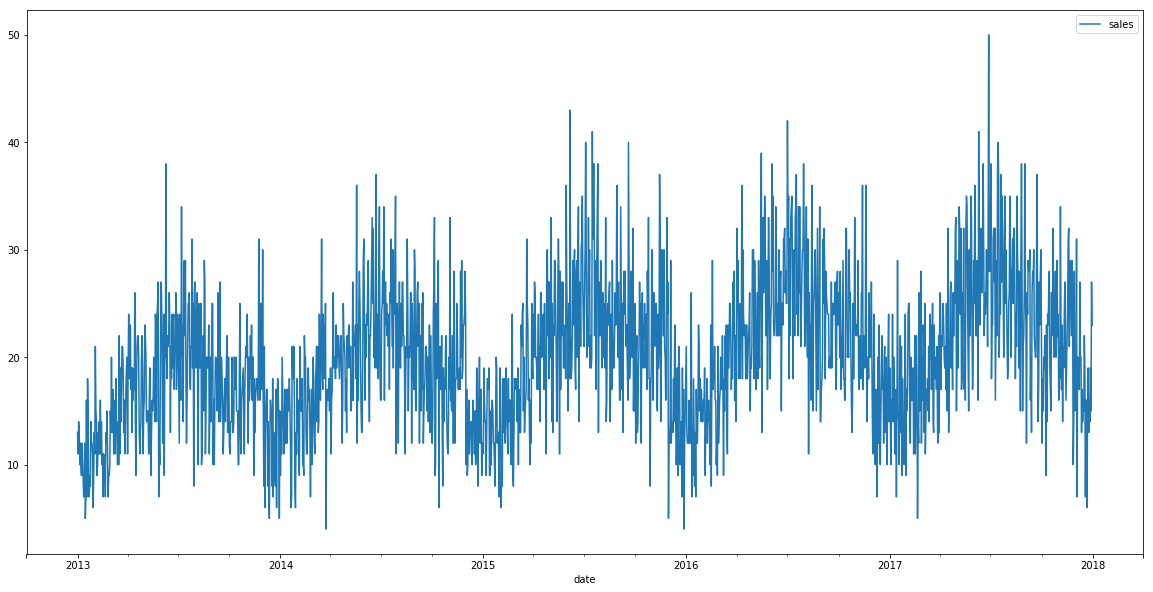

In [12]:
filtered_data.plot(figsize=(20,10))

Removing leap days from dataframe

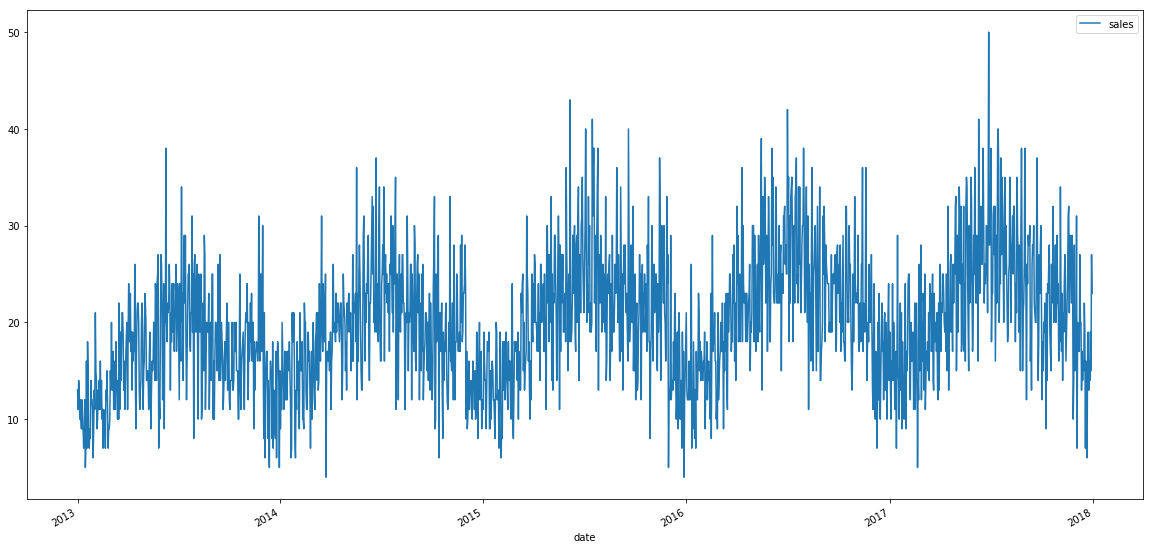

In [13]:
filtered_data = filtered_data[filtered_data.index != '2016-02-29']
filtered_data.plot()

Splitting data into test and training sets

In [98]:
test_data = filtered_data['2017']
filtered_data.drop(index=pd.date_range(start='2017-01-01', end='2017-12-31'), inplace=True)

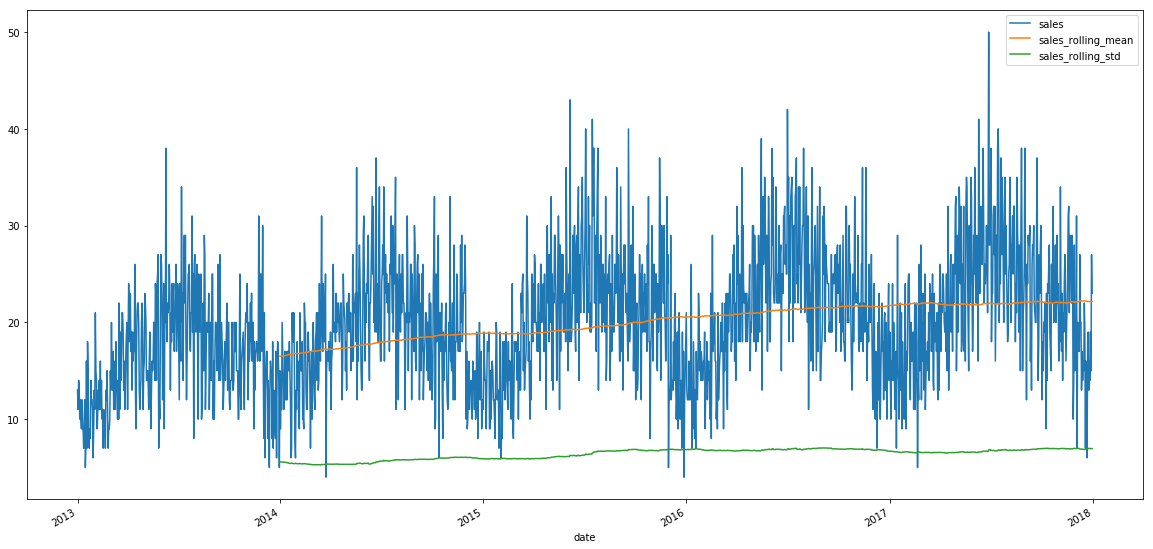

In [14]:
sales_rolling_mean = filtered_data.rolling(window=365).agg({'sales': 'mean'})
sales_rolling_std = filtered_data.rolling(window=365).agg({'sales': 'std'})
sales_rolling = sales_rolling_mean.join(sales_rolling_std, lsuffix='_rolling_mean', rsuffix='_rolling_std')
filtered_data.join(sales_rolling).plot()

In [15]:
from statsmodels.tsa.stattools import adfuller


def test_stationarity(timeseries):
    '''
    Perform Dickey-Fuller test.
    '''
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    

def plot_rolling(timeseries, column, window):
    '''
    Plot rolling mean and rolling standard deviation of given column in timeseries.
    '''
    rolling_mean = timeseries.rolling(window=window).agg({column: 'mean'})
    rolling_std = timeseries.rolling(window=window).agg({column: 'std'})
    rolling = rolling_mean.join(rolling_std, lsuffix='_rolling_mean', rsuffix='_rolling_std')
    timeseries.join(rolling).plot()

In [16]:
test_stationarity(filtered_data['sales'])

Results of Dickey-Fuller Test:
Test Statistic                   -3.160535
p-value                           0.022386
#Lags Used                       23.000000
Number of Observations Used    1801.000000
Critical Value (1%)              -3.433986
Critical Value (5%)              -2.863146
Critical Value (10%)             -2.567625
dtype: float64


**Test statistic < 5% critical value**  
We can say with **95%** confidence that the given time series is stationary.

In [17]:
log_filtered_data = np.log(filtered_data)
log_filtered_data.head()

,sales
date,
2013-01-01,2.564949
2013-01-02,2.397895
2013-01-03,2.639057
2013-01-04,2.564949
2013-01-05,2.302585


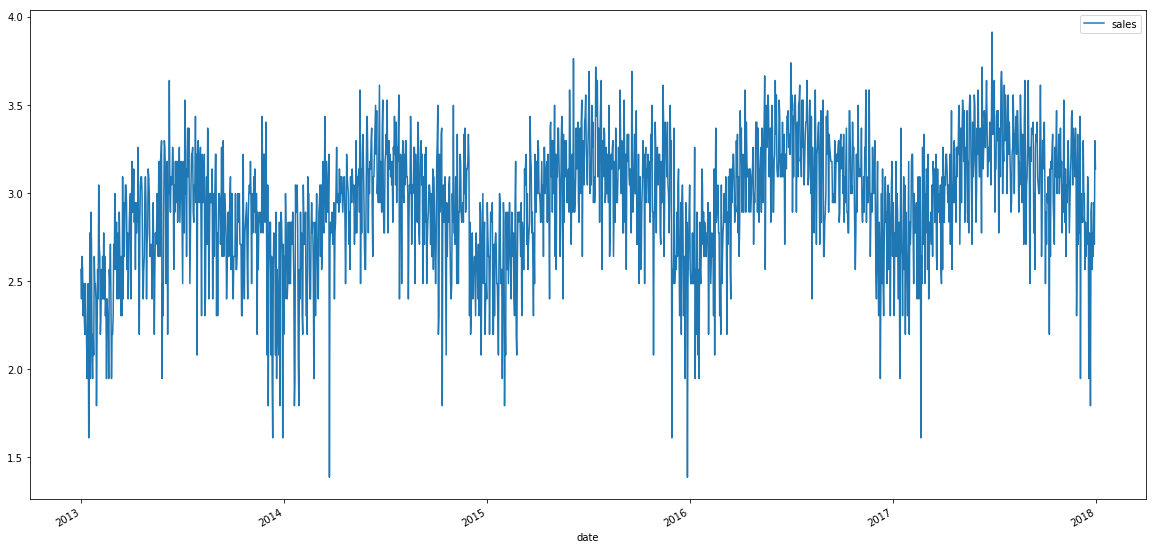

In [18]:
log_filtered_data.plot(y='sales', figsize=(20,10))

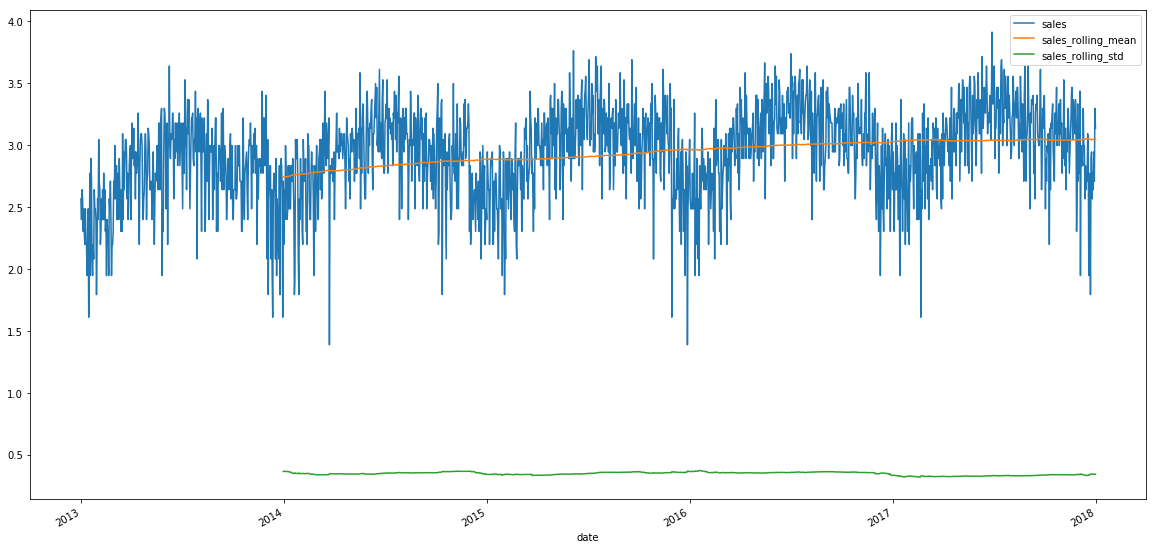

In [19]:
plot_rolling(log_filtered_data, 'sales', 365)

In [20]:
test_stationarity(log_filtered_data['sales'])

Results of Dickey-Fuller Test:
Test Statistic                   -3.599571
p-value                           0.005769
#Lags Used                       23.000000
Number of Observations Used    1801.000000
Critical Value (1%)              -3.433986
Critical Value (5%)              -2.863146
Critical Value (10%)             -2.567625
dtype: float64


We get even better result with log transform of the filtered data.

**Test Statistic < 1% critical value**

So we can say with **99%** confidence that the log transform of given timeseries is stationary.

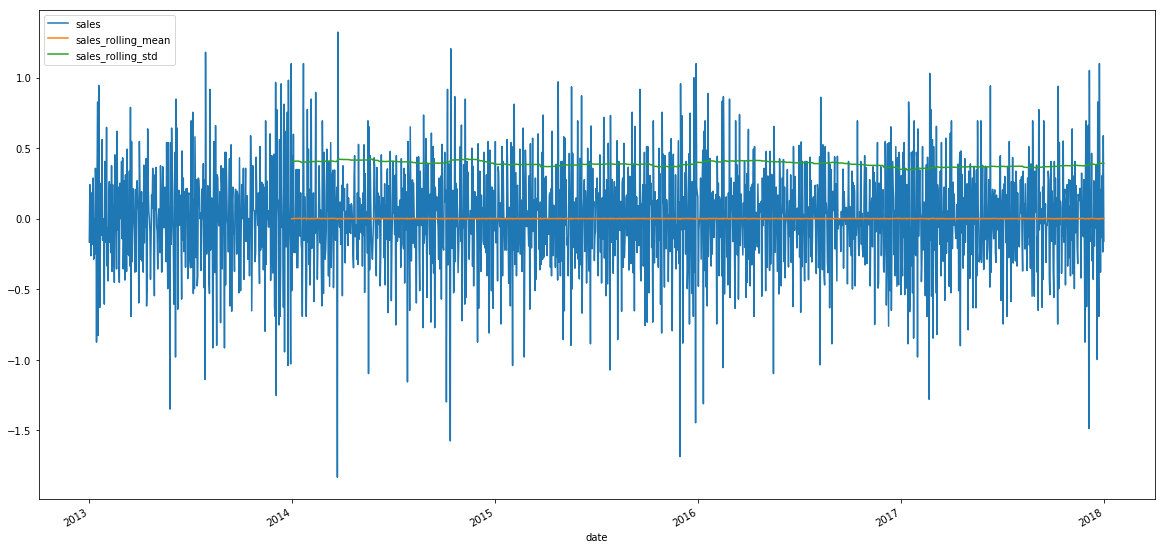

In [177]:
# log_diff = log_filtered_data - log_filtered_data.shift()
# plot_rolling(log_diff, 'sales', 365)

In [22]:
# log_diff.dropna(inplace=True)
# print(log_diff.head())
# test_stationarity(log_diff['sales'])

In [179]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [180]:
decomposition = seasonal_decompose(log_filtered_data, freq=365)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

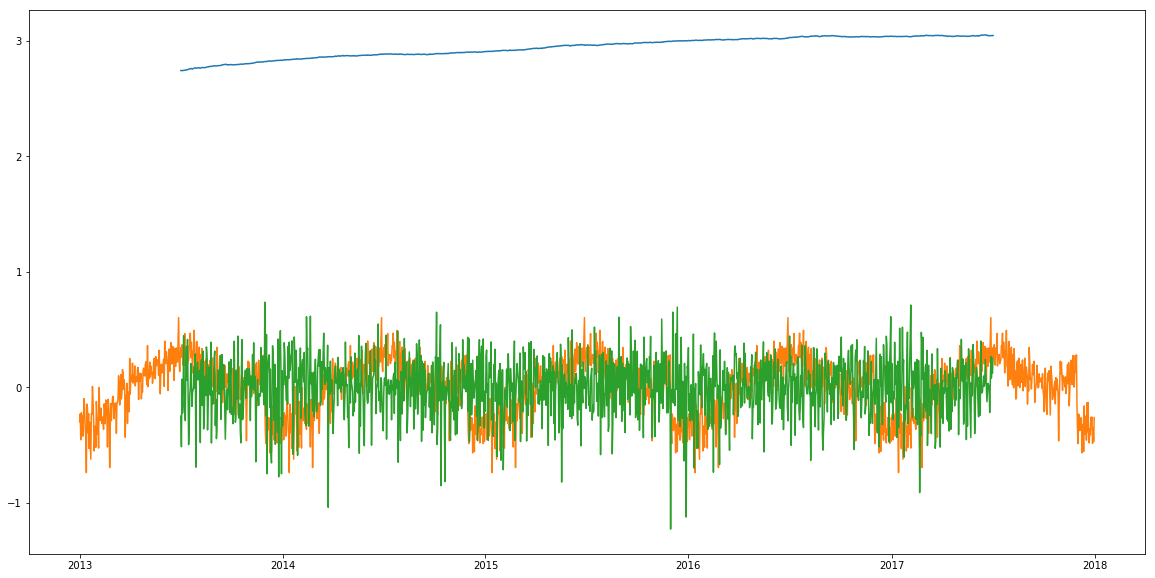

In [181]:
plt.plot(trend)
plt.plot(seasonal)
plt.plot(residual)

Results of Dickey-Fuller Test:
Test Statistic                -7.313944e+00
p-value                        1.243381e-10
#Lags Used                     2.000000e+01
Number of Observations Used    1.440000e+03
Critical Value (1%)           -3.434899e+00
Critical Value (5%)           -2.863549e+00
Critical Value (10%)          -2.567840e+00
dtype: float64


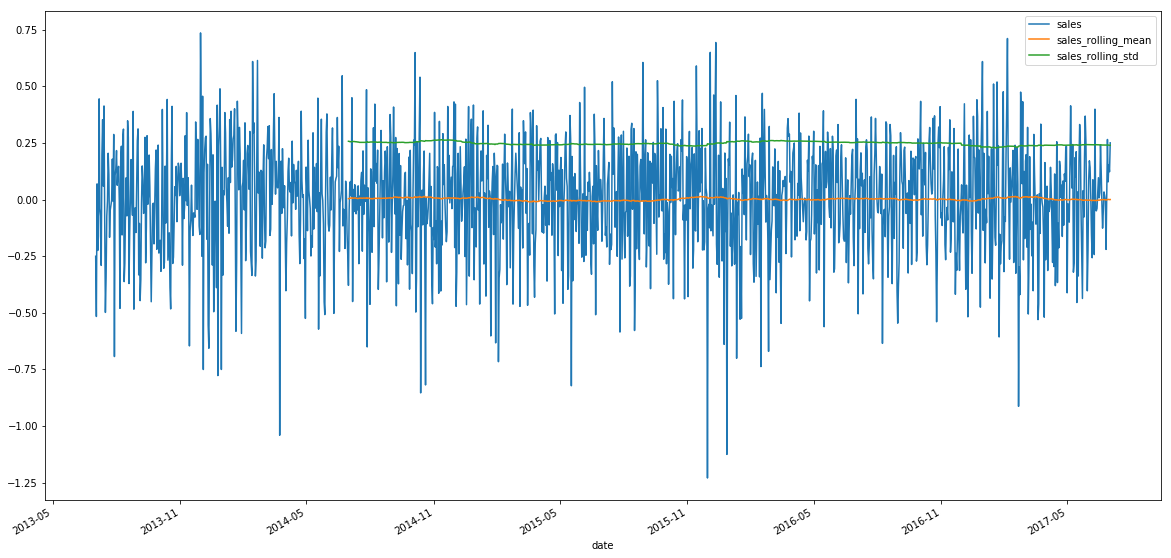

In [182]:
residual.dropna(inplace=True)
plot_rolling(residual, 'sales', 365)
test_stationarity(residual['sales'])

In [27]:
from statsmodels.tsa.stattools import acf, pacf

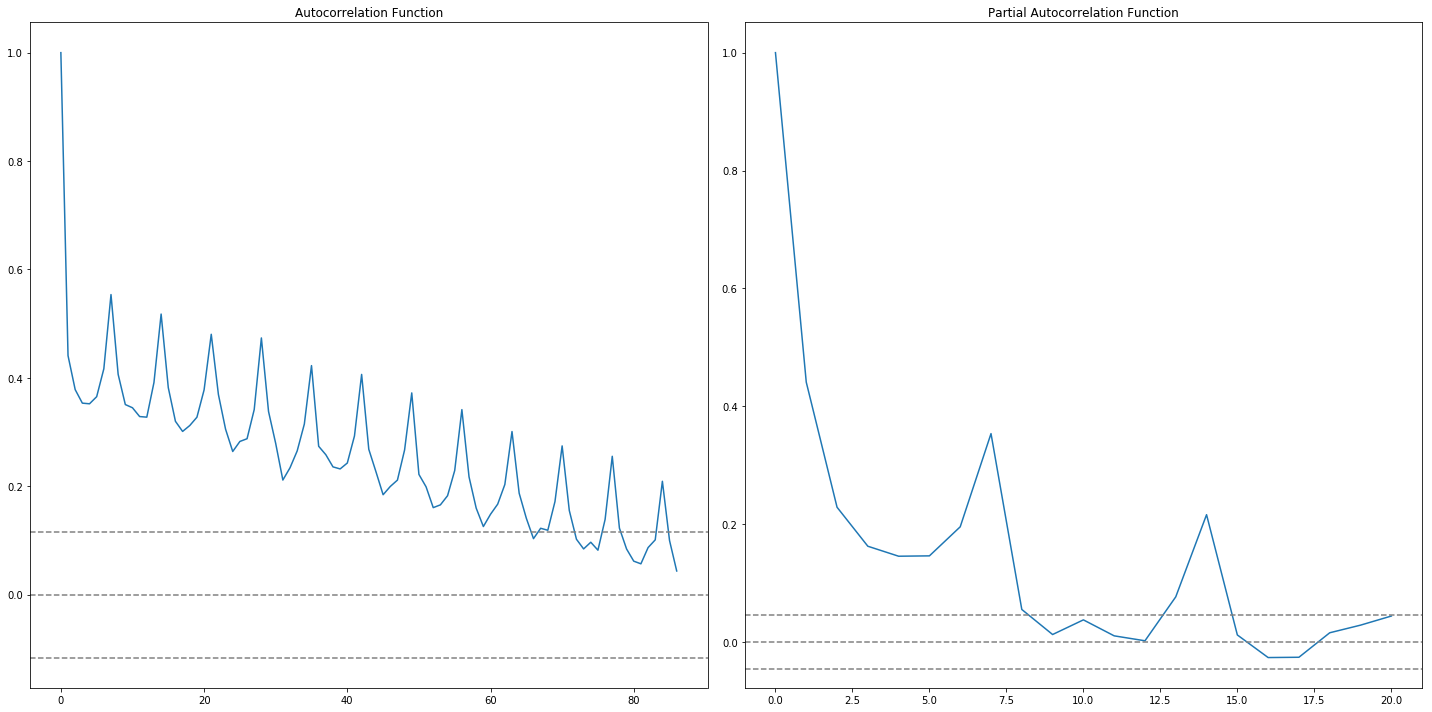

In [28]:
lag_acf = acf(log_filtered_data['sales'], nlags=86)
lag_pacf = pacf(log_filtered_data['sales'], nlags=20, method='ols')

#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-4.96/np.sqrt(len(log_filtered_data)),linestyle='--',color='gray')
plt.axhline(y=4.96/np.sqrt(len(log_filtered_data)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(log_filtered_data)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(log_filtered_data)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

So, ideally `p = 85` and `q = 8`.
But, let's just use `p = 15` for now.

In [29]:
from statsmodels.tsa.arima_model import ARIMA

/home/whatman/Projects/personal/py3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/whatman/Projects/personal/py3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/whatman/Projects/personal/py3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


date
2013-01-01    2.894553
2013-01-02    2.745175
2013-01-03    2.641278
2013-01-04    2.662233
2013-01-05    2.659007
dtype: float64

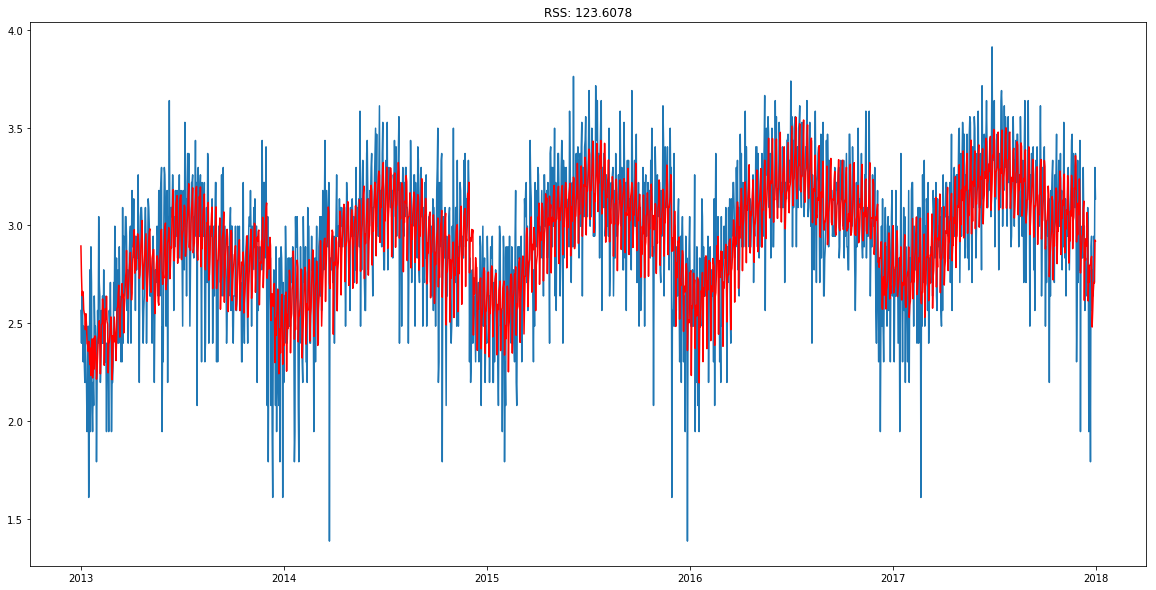

In [30]:
model = ARIMA(log_filtered_data['sales'], order=(15, 0, 8))  
results_ARIMA = model.fit(disp=1, maxiter=1000)  
plt.plot(log_filtered_data)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues - log_filtered_data['sales'])**2))
results_ARIMA.fittedvalues.head()

Let's save this model so that we can reuse it later.

In [38]:
import pickle

In [51]:
with open('sales_arima.mdl', 'wb') as f:
    pickle.dump(results_ARIMA, f)

In [56]:
with open('sales_arima.mdl', 'rb') as mdl:
    model = pickle.load(mdl)

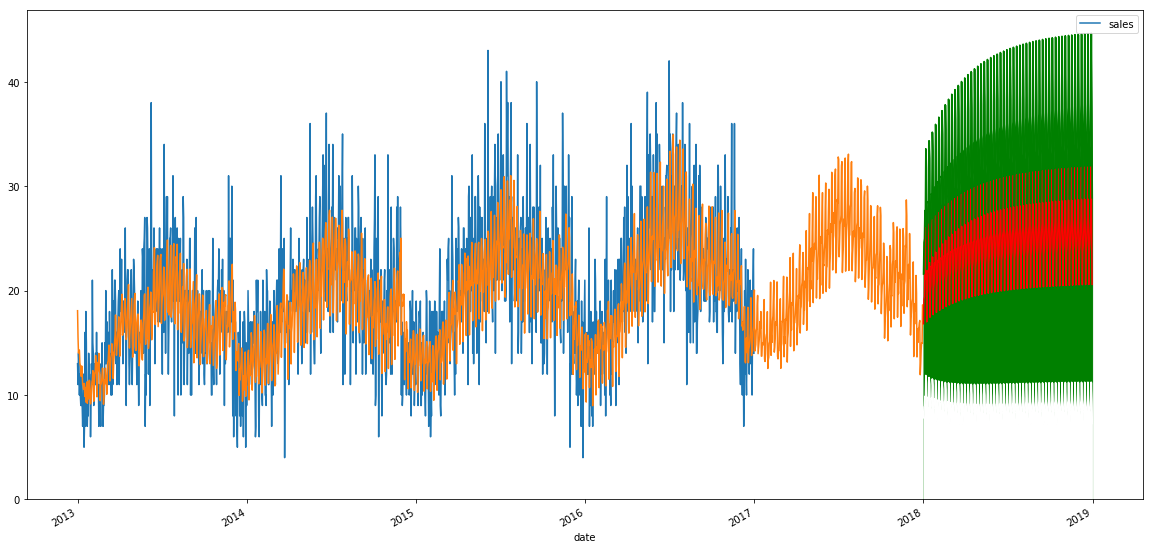

In [185]:
forecast_dates = pd.date_range(start='2018-01-01', end='2018-12-31')
forecast_arrays = model.forecast(steps=365)
total = forecast_arrays[0] + forecast_arrays[1]
forecasts = pd.Series(data=np.exp(total), index=forecast_dates)

fit_data = np.exp(results_ARIMA.fittedvalues)
filtered_data.plot()
fit_data.plot()
forecasts.plot(color='red')

conf_int = model.forecast(steps=365)[2]
lower_lim = []
upper_lim = []
for x in conf_int:
    lower_lim.append(x[0])
    upper_lim.append(x[1])

forecast_low = pd.Series(data=np.exp(lower_lim), index=forecast_dates)
forecast_up = pd.Series(data=np.exp(upper_lim), index=forecast_dates)

forecast_up.plot(kind='area', color='green')
forecast_low.plot(kind='area', color='white')